# Data Augmentation For Object Detection

This notebook serves as general manual to using this codebase. We cover all the major augmentations, as well as ways to combine them. 

In [4]:
!pip install opencv-python

  Using cached opencv_python-4.7.0.72-cp37-abi3-win_amd64.whl (38.2 MB)


In [2]:
from data_aug.data_aug import *
from data_aug.bbox_util import *
import numpy as np 
import cv2 
import matplotlib.pyplot as plt 
import pickle as pkl
# %matplotlib inline

## Storage Format 

First things first, we define how the storage formats required for images to work. 
1. **The Image**: A OpenCV numpy array, of shape *(H x W x C)*. 
2. **Annotations**: A numpy array of shape *N x 5* where *N* is the number of objects, one represented by each row. 5 columns represent the top-left x-coordinate, top-left y-coordinate, bottom-right x-coordinate, bottom-right y-coordinate, and the class of the object. 

Here is an image to aid your imagination. 

![Annotation Format](ann_form.jpg)

Whatever format your annotations are present in make sure, you convert them to this format.

For demonstration purposes, we will be using the image above to show the transformations. The image as well as it's annotation has been provided. The annotation is a numpy array in a pickled format. 

In [6]:
img = cv2.imread("messi.jpg")[:,:,::-1]   #opencv loads images in bgr. the [:,:,::-1] does bgr -> rgb
bboxes = pkl.load(open("messi_ann.pkl", "rb"))

#inspect the bounding boxes
print(bboxes)

[[ 53.         68.0000175 405.        478.9998225   0.       ]
 [202.         20.99992   496.        486.99978     0.       ]
 [589.         77.0001275 737.        335.9999825   0.       ]
 [723.        327.000125  793.        396.000295    1.       ]]


In [39]:
grades = [
[7. , 0. , 183. , 114. , 1.],
[59. , 0. , 271. , 232. , 1.],    
[262. , 0. , 410. , 144. , 1.],   
[387. , 0. , 526. , 146. , 1.],   
[510. , 0. , 645. , 137. , 1.],   
[637. , 0. , 762. , 121. , 1.],   
[770. , 0. , 922. , 151. , 1.],   
[884. , 0. , 1102. , 141. , 1.],  
[1053. , 54. , 1197. , 226. , 1.],
[947. , 112. , 1051. , 246. , 1.],
[839. , 132. , 957. , 242. , 1.], 
[3. , 216. , 221. , 548. , 1.],
[167. , 180. , 365. , 548. , 1.],
[343. , 246. , 511. , 626. , 1.],
[421. , 99. , 631. , 506. , 1.],
[619. , 91. , 819. , 494. , 1.],
[1025. , 270. , 1199. , 607. , 1.],
[745. , 236. , 931. , 650. , 1.],
[915. , 348. , 1197. , 784. , 1.],
[843. , 578. , 1011. , 764. , 1.],
[535. , 452. , 731. , 718. , 1.],
[287. , 520. , 463. , 810. , 1.],
[707. , 658. , 901. , 882. , 1.],
[549. , 694. , 709. , 890. , 1.],
[27. , 616. , 229. , 878. , 1.],
[185. , 606. , 341. , 882. , 1.],
]
f = open('cucumber.pkl', 'wb')   # Pickle file is newly created where foo1.py is
pkl.dump(np.array(grades), f)          # dump data to f
f.close()

In [3]:
img = cv2.imread("30.jpg")[:,:,::-1]   #opencv loads images in bgr. the [:,:,::-1] does bgr -> rgb
bboxes = pkl.load(open("cucumber.pkl", "rb"))

#inspect the bounding boxes
print(bboxes)

[[7.000e+00 0.000e+00 1.830e+02 1.140e+02 1.000e+00]
 [5.900e+01 0.000e+00 2.710e+02 2.320e+02 1.000e+00]
 [2.620e+02 0.000e+00 4.100e+02 1.440e+02 1.000e+00]
 [3.870e+02 0.000e+00 5.260e+02 1.460e+02 1.000e+00]
 [5.100e+02 0.000e+00 6.450e+02 1.370e+02 1.000e+00]
 [6.370e+02 0.000e+00 7.620e+02 1.210e+02 1.000e+00]
 [7.700e+02 0.000e+00 9.220e+02 1.510e+02 1.000e+00]
 [8.840e+02 0.000e+00 1.102e+03 1.410e+02 1.000e+00]
 [1.053e+03 5.400e+01 1.197e+03 2.260e+02 1.000e+00]
 [9.470e+02 1.120e+02 1.051e+03 2.460e+02 1.000e+00]
 [8.390e+02 1.320e+02 9.570e+02 2.420e+02 1.000e+00]
 [3.000e+00 2.160e+02 2.210e+02 5.480e+02 1.000e+00]
 [1.670e+02 1.800e+02 3.650e+02 5.480e+02 1.000e+00]
 [3.430e+02 2.460e+02 5.110e+02 6.260e+02 1.000e+00]
 [4.210e+02 9.900e+01 6.310e+02 5.060e+02 1.000e+00]
 [6.190e+02 9.100e+01 8.190e+02 4.940e+02 1.000e+00]
 [1.025e+03 2.700e+02 1.199e+03 6.070e+02 1.000e+00]
 [7.450e+02 2.360e+02 9.310e+02 6.500e+02 1.000e+00]
 [9.150e+02 3.480e+02 1.197e+03 7.840e+02 1.00

You can use the function `draw_rect` to plot the bounding boxes on an image. 

In [ ]:
plotted_img = draw_rect(img, bboxes)
plt.imshow(plotted_img)
plt.show()


Now, we can get started with our image augmentations. The first one is **Horizontal Flipping**. The function takes one arguement, *p* which is the probability that the image will be flipped. 

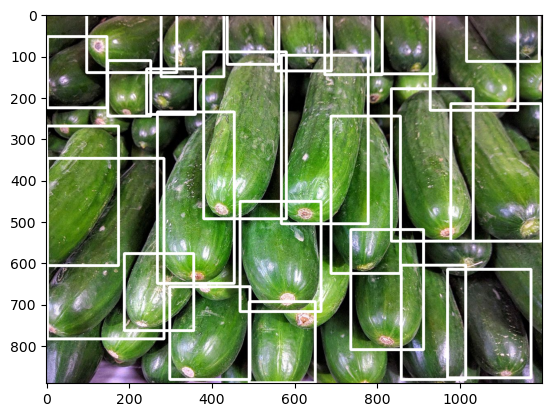

In [19]:
img_, bboxes_ = RandomHorizontalFlip(1)(img.copy(), bboxes.copy())
cv2.imwrite('smpl.jpg',img_.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

**Scaling**. Scales the image. If the argument *diff* is True, then the image is scaled with different values in the vertical and the horizontal directions, i.e. aspect ratio is not maintained. 

If the first argument is a float, then the scaling factors for both x and y directions are randomly sampled from *(- arg, arg)*. Otherwise, you can specify a tuple for this range.

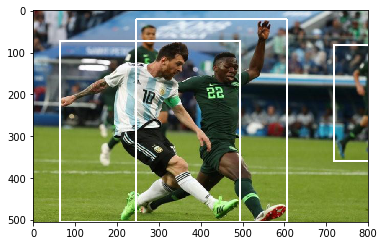

In [5]:
img_, bboxes_ = RandomScale(0.3, diff = True)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

**Translation**. Translates the image. If the argument *diff* is True, then the image is translated with different values in the vertical and the horizontal directions.

If the first argument is a float, then the translating factors for both x and y directions are randomly sampled from *(- arg, arg)*. Otherwise, you can specify a tuple for this range.

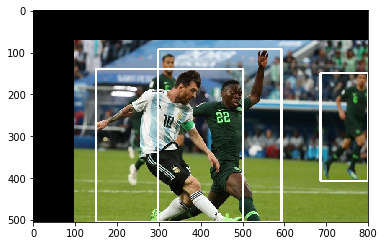

In [6]:
img_, bboxes_ = RandomTranslate(0.3, diff = True)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

**Rotation**. Rotates the image. 

If the first argument is a int, then the rotating angle, in degrees, is sampled from *(- arg, arg)*. Otherwise, you can specify a tuple for this range.

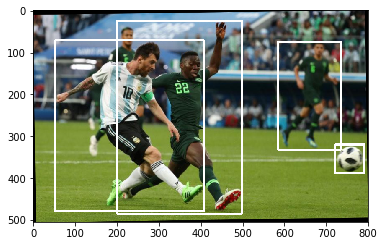

In [7]:
img_, bboxes_ = RandomRotate(20)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

**Shearing**. Sheares the image horizontally

If the first argument is a float, then the shearing factor is sampled from *(- arg, arg)*. Otherwise, you can specify a tuple for this range.

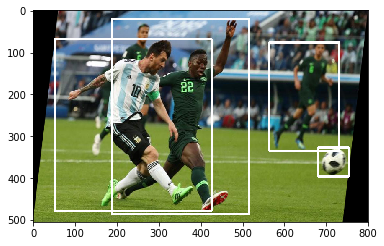

In [8]:
img_, bboxes_ = RandomShear(0.2)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

**Resizing**.  Resizes the image to square dimensions while keeping the aspect ratio constant.

The argument to this augmentation is the side of the square.

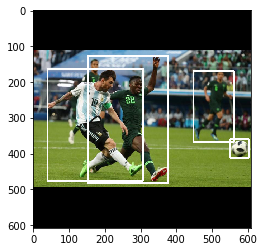

In [9]:
img_, bboxes_ = Resize(608)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

HSV transforms are supported as well. 

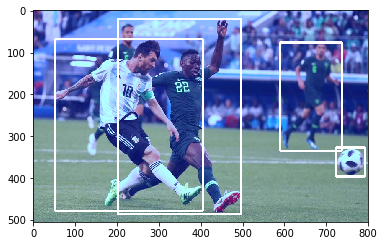

In [10]:
img_, bboxes_ = RandomHSV(100, 100, 100)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

You can combine multiple transforms together by using the Sequence class as follows. 

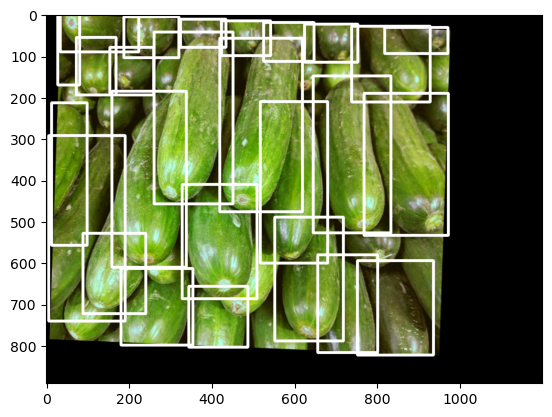

In [25]:

seq = Sequence([RandomHSV(40, 40, 30),RandomHorizontalFlip(), RandomScale(diff = True), RandomTranslate(), RandomRotate(10), RandomShear()])
img_, bboxes_ = seq(img.copy(), bboxes.copy())
cv2.imwrite('smpl2.jpg',img_.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

A list of all possible transforms can be found in the `docs` folder.




